In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Numpy Version: 1.19.4
# Pandas Version: 1.2.4
# Scipy Version: 1.5.4
# Plotly Version: 5.2.1
# Matplotlib Version: 3.3.4
# Seaborn Version: 0.11.1
# yfinance Version: 0.1.64
# Sklearn Version: 0.23.2

In [ ]:
# start = '2019-01-01'
# end = '2021-02-03'

In [ ]:
data = pd.read_csv('NiftyHistoricalData.csv')
# data = pd.read_csv('NiftyHistoricalData.csv', index_col=0)
# data = yf.download('GME', start = start, end = end)

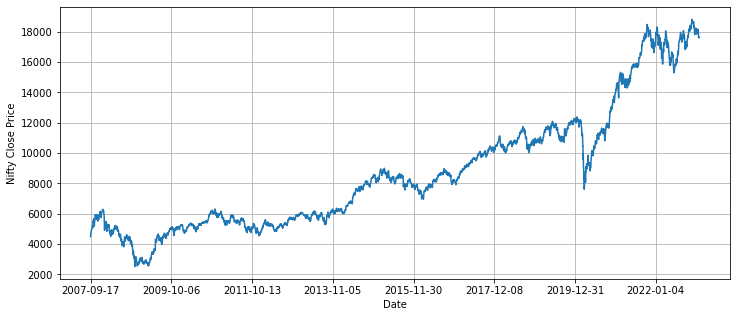

In [ ]:
plt.figure(figsize=(12,5))
data.set_index('Date')['Close'].plot()
plt.ylabel('Nifty Close Price')
plt.grid()

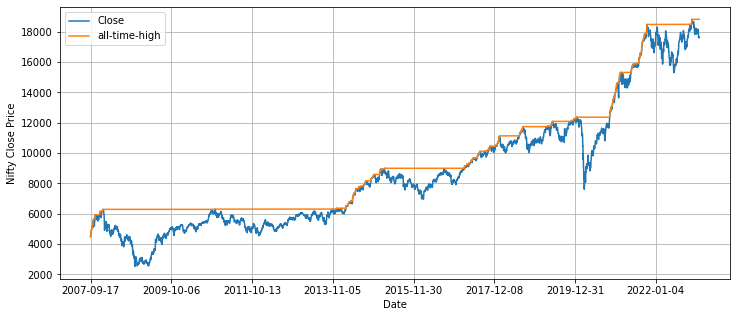

In [ ]:
import plotly.express as px
data['all-time-high'] = data['Close'].expanding().max()
data['pullback'] = 1 - data['Close'] / data['all-time-high']

plt.figure(figsize=(12,5))
data.set_index('Date')['Close'].plot()
data.set_index('Date')['all-time-high'].plot()
plt.ylabel('Nifty Close Price')
plt.grid()
plt.legend()

In [ ]:
def get_signal(data):
    pullback = data['pullback']
    
    if pullback >= 0.4:
        return '>40% dd'
    elif pullback >= 0.2:
        return '>20% dd'
    elif pullback >= 0.1:
        return '>10% dd'
    else: 
        return '< 10% dd'

data['signal'] = data.apply(get_signal, axis=1)
#print (data)
display(px.scatter(data, x='Date', y='pullback', color='signal'))

data['count_value'] = 1
display(px.pie(data.groupby('signal').agg({'count_value': 'count'}).reset_index(), values='count_value', names='signal'))

In [ ]:
# creating backtest and position classes

class Position:
    def __init__(self, open_datetime, open_price, order_type, volume, sl, tp, comment):
        self.open_datetime = open_datetime
        self.open_price = open_price
        self.order_type = order_type
        self.volume = volume
        self.sl = sl
        self.tp = tp
        self.close_datetime = None
        self.close_price = None
        self.profit = None
        self.status = 'open'
        self.comment = comment
        
    def close_position(self, close_datetime, close_price):
        self.close_datetime = close_datetime
        self.close_price = close_price
        self.profit = (self.close_price - self.open_price) * self.volume if self.order_type == 'buy' \
                                                                        else (self.open_price - self.close_price) * self.volume
        self.status = 'closed'
        
    def _asdict(self):
        return {
            'open_datetime': self.open_datetime,
            'open_price': self.open_price,
            'order_type': self.order_type,
            'volume': self.volume,
            'sl': self.sl,
            'tp': self.tp,
            'close_datetime': self.close_datetime,
            'close_price': self.close_price,
            'profit': self.profit,
            'status': self.status,
        }
        
        
class Strategy:
    def __init__(self, data, starting_balance, volume):
        self.starting_balance = starting_balance
        self.volume = volume
        self.positions = []
        self.data = data
        self.trading_allowed = True
        
    def get_positions_data(self):
        data = pd.DataFrame([position._asdict() for position in self.positions])
        data['pnl'] =data['profit'].cumsum() + self.starting_balance
        return data
        
    def add_position(self, position):
        self.positions.append(position)
        
        return True
    
    def trade(self, pullback, data):
        self.trading_allowed = True
        if data.signal == pullback:
            for pos in self.positions:
                if pos.status == 'open' and pos.comment == pullback:
                    self.trading_allowed = False
                    break
            if self.trading_allowed:
#                 self.add_position(Position(data.time, data.close, 'buy', self.volume, 0.0, 0.0, pullback))
                self.add_position(Position(data.Date, data.Close, 'buy', self.volume, 0.0, 0.0, pullback))
        
        
# logic
    def run(self):
        for i, data in self.data.iterrows():
            
            # opening positions at different dd levels
            self.trade('>10% dd', data)
            self.trade('>20% dd', data)
            self.trade('>40% dd', data)
            
            # if pullback is 0, close all positions
            if data.pullback == 0.0:
                for pos in self.positions:
                    if pos.status == 'open':
#                         pos.close_position(data.time, data.close)
                         pos.close_position(data.Date, data.Close)
        
        return self.get_positions_data()

In [ ]:
buy_dd_strategy = Strategy(data, 10000, 1)
result = buy_dd_strategy.run()

display(result)
display(px.line(result, x='open_datetime', y='pnl'))

,open_datetime,open_price,order_type,volume,sl,tp,close_datetime,close_price,profit,status,pnl
0,2008-01-21,5208.799805,buy,1,0.0,0.0,2010-11-09,6301.549805,1092.750000,closed,11092.750000
1,2008-01-22,4899.299805,buy,1,0.0,0.0,2010-11-09,6301.549805,1402.250000,closed,12495.000000
2,2008-10-06,3602.350098,buy,1,0.0,0.0,2010-11-09,6301.549805,2699.199707,closed,15194.199707
3,2011-01-14,5654.549805,buy,1,0.0,0.0,2013-11-01,6307.200195,652.650391,closed,15846.850098
4,2011-08-16,5035.799805,buy,1,0.0,0.0,2013-11-01,6307.200195,1271.400391,closed,17118.250488
5,2015-05-07,8057.299805,buy,1,0.0,0.0,2017-03-14,9087.000000,1029.700195,closed,18147.950684
6,2016-02-11,6976.350098,buy,1,0.0,0.0,2017-03-14,9087.000000,2110.649902,closed,20258.600586
7,2018-03-23,9998.049805,buy,1,0.0,0.0,2018-07-24,11134.299805,1136.250000,closed,21394.850586
8,2018-10-05,10316.450195,buy,1,0.0,0.0,2019-04-16,11787.150391,1470.700195,closed,22865.550781
9,2019-08-05,10862.599609,buy,1,0.0,0.0,2019-11-27,12100.700195,1238.100586,closed,24103.651367
